# Download and process OpenRainER dataset

This notebook 
* downloads the dataset available on Zenodo https://doi.org/10.5281/zenodo.10593848
* crops to shorter periods 
* transforms into a common data structure
* shows some statisitcs and comparisons of the CML and reference data
* does some basic CML processing
* and saves to NetCDF

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import opensense_data_downloader_and_transformer as oddt
import pycomlink as pycml
import glob as glob
import pandas as pd
import poligrain as plg
import pyproj
import gzip, tarfile
import zipfile
import shutil
import os

## Download full dataset

In [3]:
# storing to external datasource as this is big due to the radar ref
oddt.download_data_file(
    url="https://zenodo.org/api/records/14731404/files-archive",
    local_path="data/OpenRainER/", 
    local_file_name='files-archive.zip', print_output=True
)

Creating path data/OpenRainER/
to data/OpenRainER//files-archive.zip


('data/OpenRainER/files-archive.zip', <http.client.HTTPMessage at 0x318366fd0>)

## Extract raw data files

This is based on the notebook and code by Eli Covi introduced here https://github.com/OpenSenseAction/radar_adjustment_intercomparison/pull/8

In [4]:
data_dir = 'data/OpenRainER/'

In [6]:
# unzip files
with zipfile.ZipFile(data_dir+'files-archive.zip') as zfile:
    zfile.extractall(data_dir)

In [7]:
#untar dowloaded files
for tar_filename in os.listdir(data_dir):
    if tar_filename.endswith('.tar'):
        tar_path = os.path.join(data_dir, tar_filename)
        
        # Estrazione del file .tar
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(data_dir)  # Estrai tutto nella stessa directory

In [9]:
# unzip through all files in the directory
for filename in os.listdir(data_dir):
    # Check if the file has a .gz extension | select only 1 month
    if (filename.endswith('.gz')) & ('202208' in filename):
        gz_path = os.path.join(data_dir, filename)
        unzipped_path = os.path.join(data_dir, filename[:-3])  # Remove the .gz extension
        
        # Unzip the file
        with gzip.open(gz_path, 'rb') as f_in:
            with open(unzipped_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Delete the original .gz file 
        os.remove(gz_path)

In [10]:
fns = sorted(glob.glob(data_dir+"/AWS_20220[7-8]*nc"))

In [11]:
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.id.values))
common_ids = list(set.intersection(*ids))

rainfall=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    tmp = tmp.sel(id=common_ids)
    rainfall.append(tmp.rainfall_amount.load())


100%|██████████| 1/1 [00:00<00:00, 63.98it/s]


In [ ]:
ds_rainfall = xr.concat(rainfall, dim='time')
ds_rainfall = ds_rainfall.rename({"longitude": "lon", "latitude": "lat"})

ds_rainfall.to_netcdf(data_dir+"AWS_rainfall.nc")

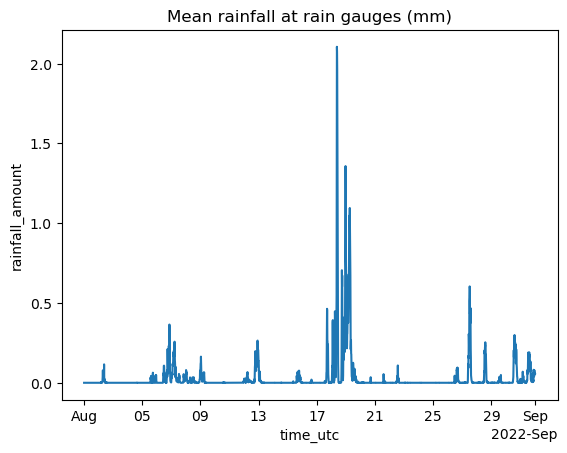

In [18]:
ds_rainfall.mean(dim='id').plot()
plt.title('Mean rainfall at rain gauges (mm)');

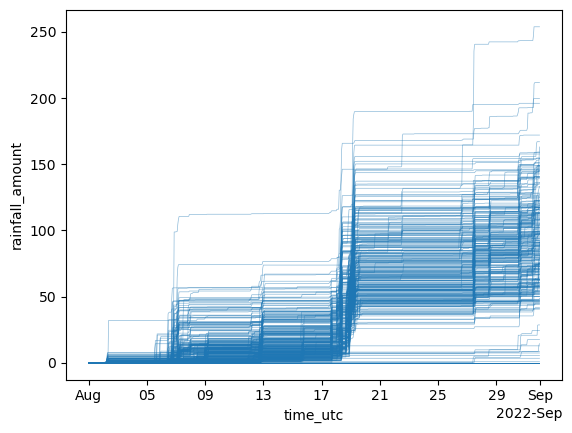

In [29]:
ds_rainfall.resample(time='1h').sum().cumsum(dim='time').plot.line(x='time', add_legend=False, color='C0', linewidth=0.5, alpha=0.5);

In [14]:
ds_rainfall.to_netcdf('OpenRainER_rain_gauges.nc')

#### Merge cmls to one dataset

In [32]:
fn

'data/OpenRainER/CML_202207010000_202207312359.nc.gz'

In [33]:
fns = sorted(glob.glob(data_dir+"CML_202208*"))
ids=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn)
    ids.append(set(tmp.cml_id.values))
common_ids = list(set.intersection(*ids))

cmls=[]
for fn in tqdm(fns):
    tmp = xr.open_dataset(fn) 
    tmp = tmp.sel(cml_id=common_ids)
    cmls.append(tmp.load())


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


In [44]:
ds_cmls = xr.concat(cmls,dim='time')

In [45]:
#ds_cmls['frequency'] = ds_cmls['frequency'].isel(time=1).drop_vars('time')
#ds_cmls['polarization'] = ds_cmls['polarization'].isel(time=1).drop_vars('time')

In [46]:
ds_cmls.nbytes/1e9

0.215550648

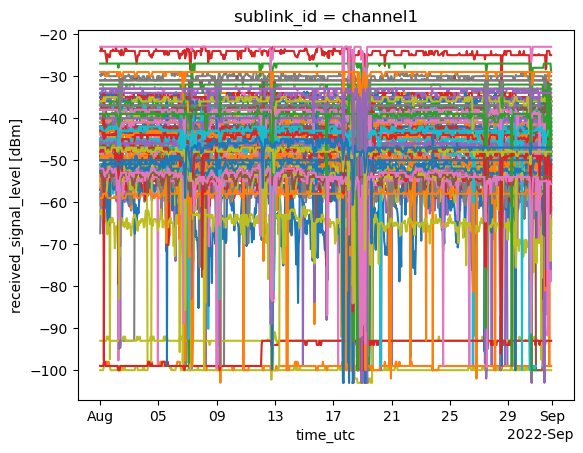

In [47]:
ds_cmls.isel(sublink_id=0).rsl.resample(time='1h').min().plot.line(x='time', add_legend=False);

## Crop to specific time period and rename datasets

In [97]:
t_start = '2022-08-14'
t_end = '2022-08-21'

ds_cmls = ds_cmls.sel(time=slice(t_start, t_end))
ds_gauges = ds_rainfall.sel(time=slice(t_start, t_end)).to_dataset()


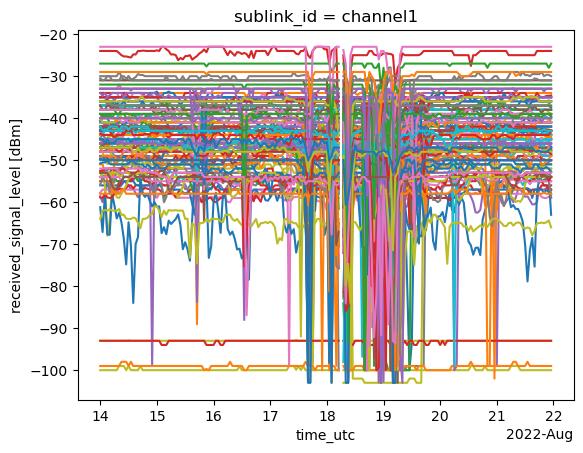

In [49]:
ds_cmls.rsl.isel(sublink_id=0).resample(time='1h').min().plot.line(x='time', add_legend=False);

## Load radar data

In [112]:
fns_radar = sorted(glob.glob(data_dir+"/RADadj_202208*"))

list_radar=[]
count=[]
for i in tqdm(range(len(fns_radar))):
    ds_radar = xr.open_dataset(fns_radar[i])
    # remove unnecessary cords and variables
    ds_radar = ds_radar.drop_vars(['geo_dim','mesh_dim','mosaic'])
    #add lon lat grid
    lon_grid, lat_grid = np.meshgrid(ds_radar.lon.values, ds_radar.lat.values)
    count.append(len(ds_radar.time))
    ds_radar.coords["lon_grid"] = (("lat", "lon"), lon_grid)
    ds_radar.coords["lat_grid"] = (("lat", "lon"), lat_grid)

    list_radar.append(ds_radar)

ds_radar_adjusted = xr.concat(list_radar, dim='time')

# fill in missing time steps
#ds_radar = ds_radar.reindex({'time':pd.date_range(ds_radar.time.min().values,ds_radar.time.max().values,freq='15min')})

100%|██████████| 1/1 [00:00<00:00, 66.36it/s]


In [113]:
fns_radar = sorted(glob.glob(data_dir+"/RADrain_202208*"))

list_radar=[]
count=[]
for i in tqdm(range(len(fns_radar))):
    ds_radar = xr.open_dataset(fns_radar[i])
    # remove unnecessary cords and variables
    ds_radar = ds_radar.drop_vars(['geo_dim','mesh_dim','mosaic'])
    #add lon lat grid
    lon_grid, lat_grid = np.meshgrid(ds_radar.lon.values, ds_radar.lat.values)
    count.append(len(ds_radar.time))
    ds_radar.coords["lon_grid"] = (("lat", "lon"), lon_grid)
    ds_radar.coords["lat_grid"] = (("lat", "lon"), lat_grid)

    list_radar.append(ds_radar)

ds_radar = xr.concat(list_radar, dim='time')

# fill in missing time steps
#ds_radar = ds_radar.reindex({'time':pd.date_range(ds_radar.time.min().values,ds_radar.time.max().values,freq='15min')})

100%|██████████| 1/1 [00:00<00:00, 84.77it/s]


In [115]:
ds_radar['R_gauge_adjusted'] = ds_radar_adjusted.rainfall_amount
ds_radar['R'] = ds_radar.rainfall_amount

ds_radar = ds_radar.drop_vars(['lon', 'lat']).rename({'lon_grid': 'lon', 'lat_grid': 'lat'})
ds_radar = ds_radar.rename_dims({'lon': 'x', 'lat': 'y'})

ds_radar = ds_radar.sel(time=slice(ds_cmls.time.min(), ds_cmls.time.max()))
ds_radar

<xarray.Dataset> Size: 998MB
Dimensions:           (time: 768, y: 290, x: 373)
Coordinates:
  * time              (time) datetime64[ns] 6kB 2022-08-14 ... 2022-08-21T23:...
    lon               (y, x) float32 433kB 8.5 8.513 8.525 ... 13.18 13.19 13.21
    lat               (y, x) float32 433kB 43.4 43.4 43.4 ... 46.0 46.0 46.0
Dimensions without coordinates: y, x
Data variables:
    rainfall_amount   (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R_gauge_adjusted  (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R                 (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
Attributes:
    title:         OpenRainER-RP: radar 15-min accumulated precipitation
    file_authors:  Elia Covi (ARPAE-SIMC Bologna (IT)); Giacomo Roversi (Ca' ...
    institution:   Hydro-Meteorological and Climate Service of Emilia-Romagna...
    date:          2025-01-01
    source:        ARPAE-SIMC, Bologna (IT) - Radar rain depth maps
    license:       https://creativecommons.org/licenses/by/4.0/
    contact:       elia.c.covi@gmail.com
    reference:     https://zenodo.org/doi/10.5281/zenodo.10593848
    version:       1.1

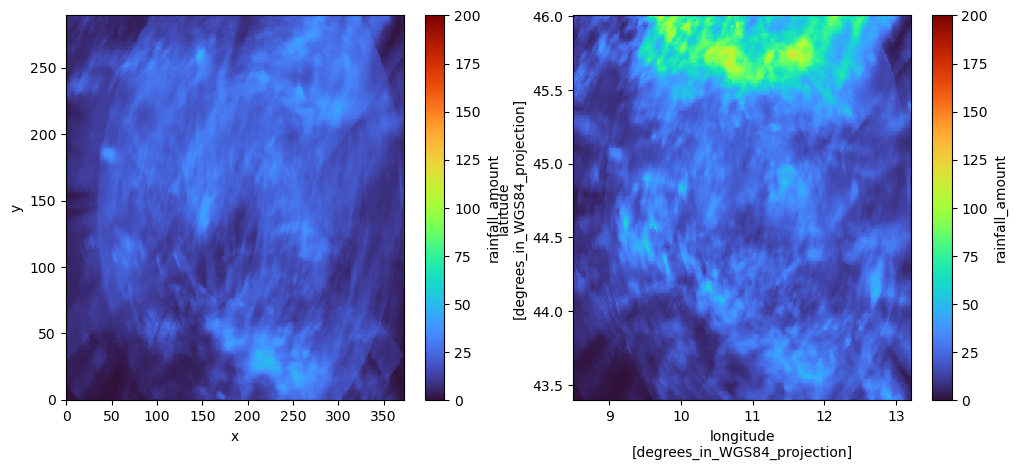

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ds_radar.rainfall_amount.resample(time='1h').mean().sum(dim='time').plot(ax=axs[0], vmin=0, vmax= 200, cmap='turbo')
ds_radar_adjusted.rainfall_amount.resample(time='1h').mean().sum(dim='time').plot(ax=axs[1], vmin=0, vmax=200, cmap='turbo')

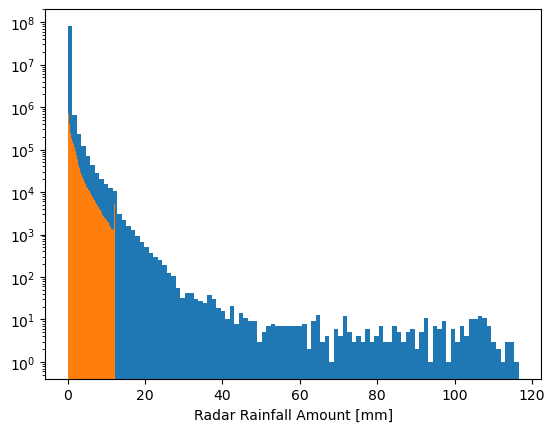

In [118]:
ds_radar.R_gauge_adjusted.plot.hist(bins=100, yscale='log');
ds_radar.R.plot.hist(bins=100, yscale='log');


## CML processing

In [119]:
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 6, center=True).std() > 2).mean(dim="time") > 0.2

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

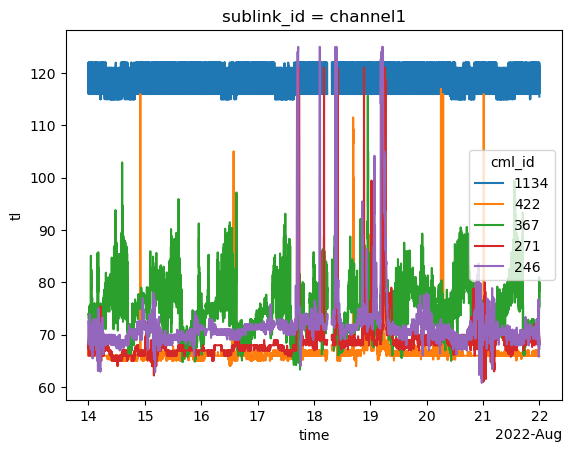

In [120]:
ds_cmls.where(qc_diurnalcicle, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

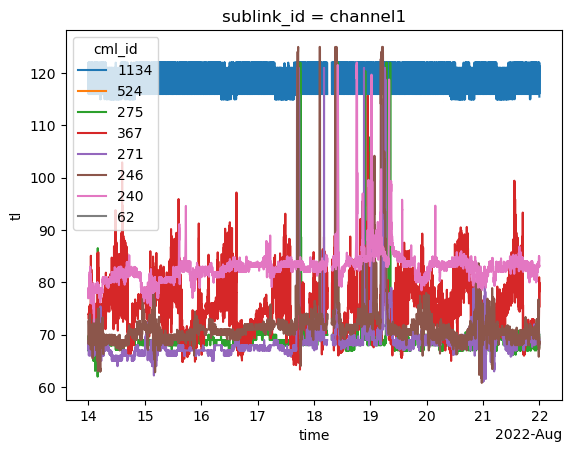

In [121]:
ds_cmls.where(qc_noisyperiods, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

In [122]:
ds_cmls

<xarray.Dataset> Size: 234MB
Dimensions:       (time: 11412, sublink_id: 2, cml_id: 151)
Coordinates:
  * time          (time) datetime64[ns] 91kB 2022-08-14 ... 2022-08-21T23:59:00
  * sublink_id    (sublink_id) <U8 64B 'channel1' 'channel2'
  * cml_id        (cml_id) <U4 2kB '412' '154' '1149' '55' ... '60' '434' '62'
    length        (cml_id) float64 1kB 6.115e+03 2.107e+03 ... 1.037e+03
    site_0_lat    (cml_id) float64 1kB 44.16 44.1 44.71 ... 44.79 44.88 44.82
    site_0_lon    (cml_id) float64 1kB 11.01 11.98 9.623 ... 9.755 11.97 9.738
    site_0_elev   (cml_id) float64 1kB 787.7 124.2 1.105e+03 ... -1.0 441.8
    site_1_lat    (cml_id) float64 1kB 44.17 44.11 44.65 ... 44.79 44.84 44.83
    site_1_lon    (cml_id) float64 1kB 11.09 12.0 9.45 ... 9.854 11.95 9.731
    site_1_elev   (cml_id) float64 1kB 671.6 366.5 1.076e+03 ... -0.9 355.8
    frequency     (cml_id, sublink_id) float64 2kB 2.456e+04 ... 2.458e+04
    polarization  (cml_id, sublink_id) object 2kB 'vertical' ... 'vertical'
Data variables:
    rsl           (cml_id, sublink_id, time) float64 28MB -36.88 -36.0 ... -48.0
    tsl           (cml_id, sublink_id, time) float64 28MB 17.0 17.0 ... 18.0
    tl            (cml_id, sublink_id, time) float64 28MB 53.88 53.0 ... 66.0
    wet           (time, cml_id) float64 14MB 0.0 0.0 0.0 0.0 ... nan nan nan
    baseline      (cml_id, sublink_id, time) float64 28MB 53.88 53.0 ... 66.0
    A_obs         (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 0.0008674
    waa           (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 0.0008555
    A             (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 1.193e-05
    R             (cml_id, sublink_id, time) float64 28MB 0.0 0.0 ... 0.0 0.0
Attributes:
    title:              OpenRainER-CML: Lepida ScpA CML received and transmit...
    file_authors:       Elia Covi (ARPAE-SIMC Bologna (IT)); Giacomo Roversi ...
    institution:        Hydro-Meteorological and Climate Service of Emilia-Ro...
    date:               2025-01-01
    source:             Lepida ScpA, Bologna (IT) https://www.lepida.net/ - C...
    naming_convention:  OpenSense-CML
    license:            https://creativecommons.org/licenses/by/4.0/
    contact:            elia.c.covi@gmail.com
    reference:          https://zenodo.org/doi/10.5281/zenodo.10593848
    version:            1.1

In [123]:
ds_radar

<xarray.Dataset> Size: 998MB
Dimensions:           (time: 768, y: 290, x: 373)
Coordinates:
  * time              (time) datetime64[ns] 6kB 2022-08-14 ... 2022-08-21T23:...
    lon               (y, x) float32 433kB 8.5 8.513 8.525 ... 13.18 13.19 13.21
    lat               (y, x) float32 433kB 43.4 43.4 43.4 ... 46.0 46.0 46.0
Dimensions without coordinates: y, x
Data variables:
    rainfall_amount   (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R_gauge_adjusted  (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
    R                 (time, y, x) float32 332MB nan nan nan nan ... 0.0 0.0 nan
Attributes:
    title:         OpenRainER-RP: radar 15-min accumulated precipitation
    file_authors:  Elia Covi (ARPAE-SIMC Bologna (IT)); Giacomo Roversi (Ca' ...
    institution:   Hydro-Meteorological and Climate Service of Emilia-Romagna...
    date:          2025-01-01
    source:        ARPAE-SIMC, Bologna (IT) - Radar rain depth maps
    license:       https://creativecommons.org/licenses/by/4.0/
    contact:       elia.c.covi@gmail.com
    reference:     https://zenodo.org/doi/10.5281/zenodo.10593848
    version:       1.1

In [124]:
# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar.R,
    ds_line_data=ds_cmls,
)

da_radar_along_cmls = grid_at_lines(ds_radar.R)
da_radar_along_cmls


# calculate wet periods
#ds_cmls['roll_std_threshold'] = 1.1 * ds_cmls['tl'].rolling(time=60, center=True).std().quantile(0.85, dim='time')
#ds_cmls['wet'] = ds_cmls.tl.rolling(time=60, center=True).std() > ds_cmls.roll_std_threshold
#ds_cmls['wet'] =    ds_cmls.tl.rolling(time=60).std() > 0.4
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)    

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  
    d=0.15, 
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  
    f_GHz=ds_cmls.frequency / 1000,  
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

## Quick analysis of processed CML data

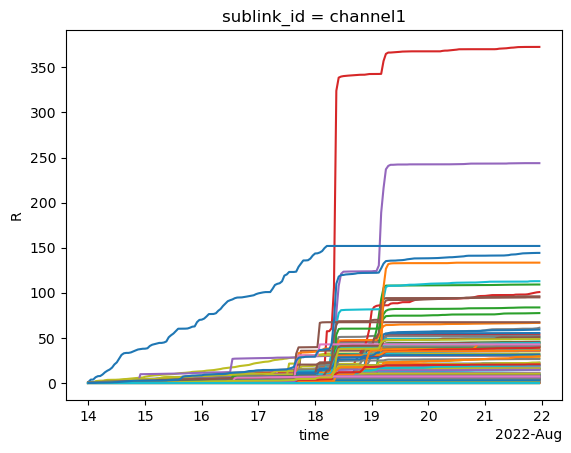

In [125]:
ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time', add_legend=False);

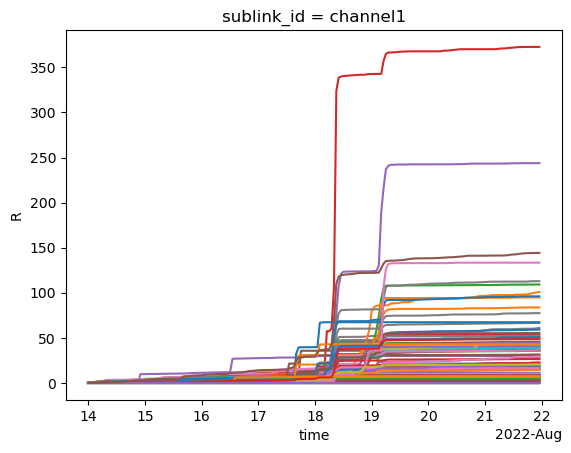

In [126]:
(
    ds_cmls
    .where(~qc_noisyperiods, drop=True)
    .isel(sublink_id=0)
    .R
    .resample(time='1h').mean()
    .cumsum(dim='time')
    .plot.line(x='time', add_legend=False)
);

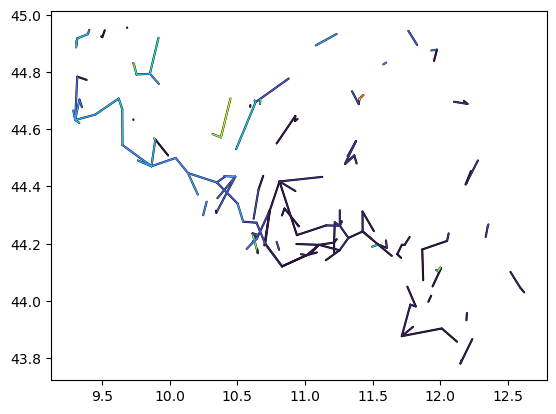

In [127]:
plg.plot_map.plot_lines(ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'), vmin=0, vmax=200)

<Axes: xlabel='lon', ylabel='lat'>

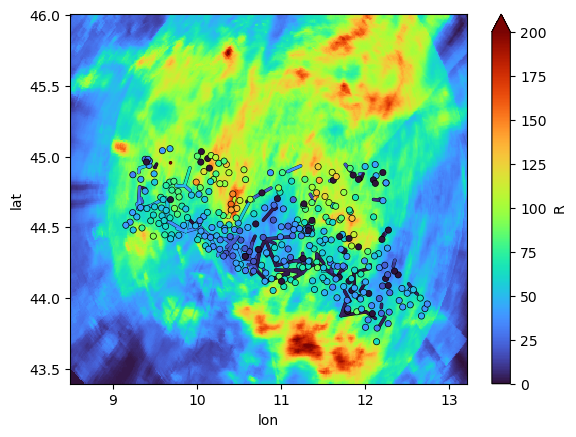

In [143]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'),
    da_grid=ds_radar.R.resample(time='1h').sum().sum(dim='time'),
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'),
    vmin=0,
    vmax=200,
)

<Axes: xlabel='lon', ylabel='lat'>

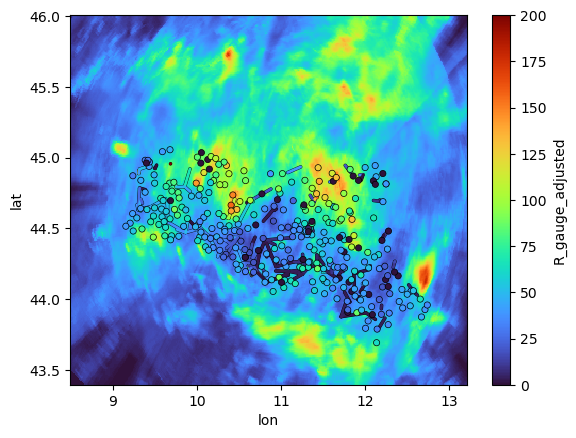

In [144]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'),
    da_grid=ds_radar.R_gauge_adjusted.resample(time='1h').sum().sum(dim='time'),
    da_gauges=ds_gauges.rainfall_amount.sum(dim='time'),
    vmin=0,
    vmax=200,
)

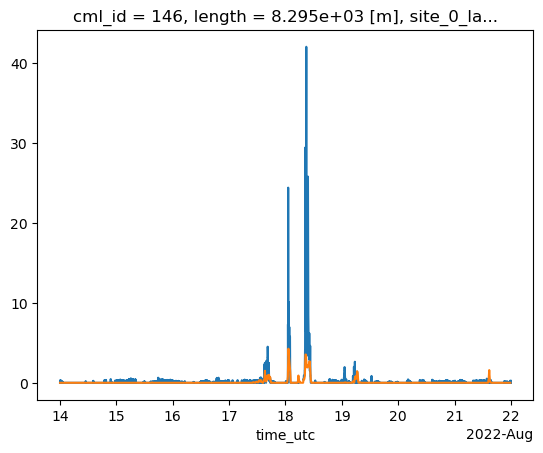

In [146]:
i = 15

ds_cmls.isel(sublink_id=0).isel(cml_id=i).R.plot()
da_radar_along_cmls.isel(cml_id=i).plot()

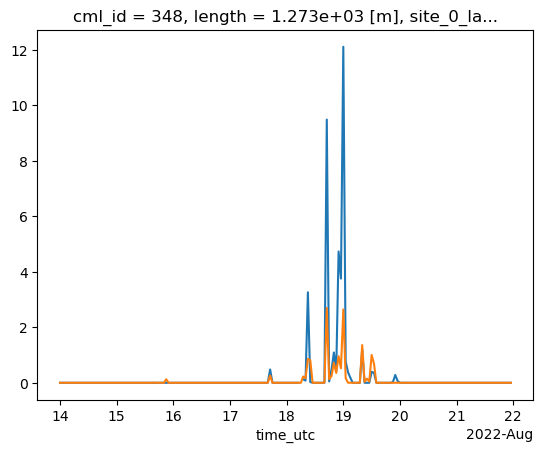

In [138]:
i = 77

ds_cmls.isel(sublink_id=0).isel(cml_id=i).R.resample(time='1h').mean().plot()
da_radar_along_cmls.isel(cml_id=i).resample(time='1h').mean().plot();

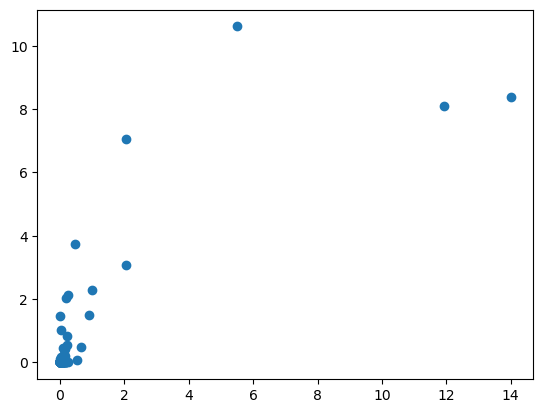

In [147]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).isel(cml_id=i).R.resample(time='1h').mean(),
    da_radar_along_cmls.isel(cml_id=i).resample(time='1h').sum(),
)

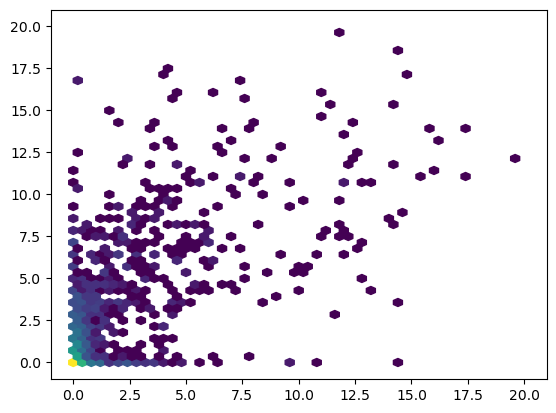

In [148]:
import matplotlib.pyplot as plt
plt.hexbin(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().data.flatten(),
    da_radar_along_cmls.resample(time='1h').sum().data.flatten(),
    gridsize=50,
    bins='log',
    extent=[0, 20, 0, 20],
)

(0.0, 200.0)

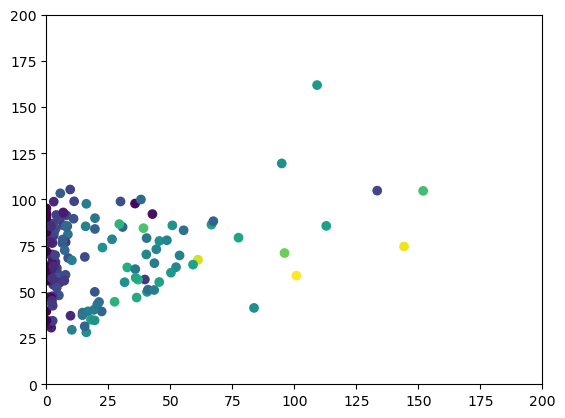

In [151]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().sum(dim='time').data,
    da_radar_along_cmls.resample(time='1h').sum().sum(dim='time').data,
    c=(ds_cmls.isel(sublink_id=0).R > 0.1).sum(dim='time'),
)
plt.xlim(0, 200)
plt.ylim(0, 200)

## Load gauge data and write selected period to NetCDF

In [5]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

ds_gauges_city = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], df_gauges_city.T),
    ),
    coords=dict(
        id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        lon=(["id"], df_gauges_city_metadata.Longitude_DecDeg),
        lat=(["id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["id"], df_gauges_city_metadata.Location),
        type=(["id"], df_gauges_city_metadata.Type),
        quantization=(["id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)
ds_gauges_city

<xarray.Dataset> Size: 12MB
Dimensions:          (id: 10, time: 132480)
Coordinates:
  * id               (id) object 80B 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 1MB 2015-06-01T00:01:00 ... 2015-0...
    lon              (id) float64 80B 11.94 12.04 12.07 ... 11.99 11.97 11.94
    lat              (id) float64 80B 57.65 57.72 57.75 ... 57.71 57.71 57.63
    location         (id) object 80B 'Järnbrottsmotet' ... 'Askim Ögärdesv'
    type             (id) object 80B 'Weighing' 'Weighing' ... 'Tipping-bucket'
    quantization     (id) float64 80B 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2
Data variables:
    rainfall_amount  (id, time) float64 11MB 0.1 0.0 0.1 0.0 ... 0.0 0.2 0.0 0.0

In [6]:
df_gauge_smhi = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        id=["SMHI"],
        time=df_gauge_smhi.index.values,
        lon=(["id"], [11.9924]),
        lat=(["id"], [57.7156]),
        location=(["id"], ["Goeteburg A"]),
        type=(["id"], ["15 min rainfall sum"]),
        quantization=(["id"], [0.1]),
    ),
)

In [7]:
ds_gauges_city = ds_gauges_city.sel(time=slice(t_start, t_end))
ds_gauges_smhi = ds_gauges_smhi.sel(time=slice(t_start, t_end))

In [8]:
ds_gauges_city.to_netcdf('../openmrg_municp_gauge_8d.nc', encoding={'rainfall_amount': {'zlib': True}})
ds_gauges_smhi.to_netcdf('../openmrg_smhi_gauge_8d.nc', encoding={'rainfall_amount':  {'zlib': True}})

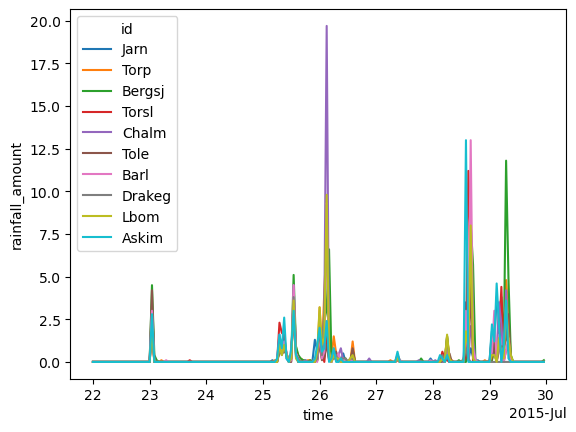

In [9]:
ds_gauges_city.rainfall_amount.resample(time='1h').sum().plot.line(x='time');

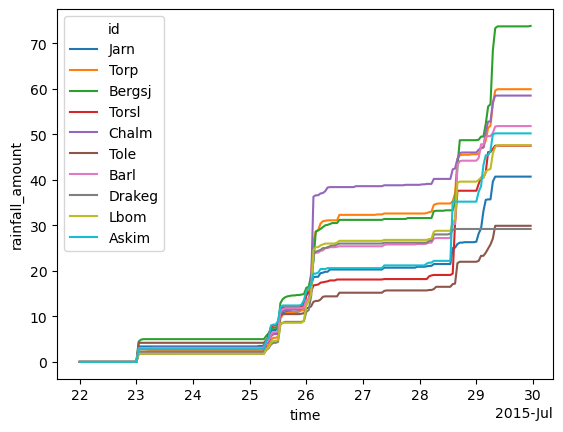

In [10]:
ds_gauges_city.rainfall_amount.resample(time='1h').sum().cumsum(dim='time').plot.line(x='time');

## Load radar data, calculate rain rates and write to NetCDF

In [11]:
ds_radar = xr.open_dataset(
    "data/andersson_2022_OpenMRG/radar/radar.nc"
)
ds_radar = ds_radar.rename_vars({'data': 'dBZ'})
# get rain rates from radar reflecitivity using values from Andersson et al (2022)
ds_radar["R"] = (10 ** (ds_radar.dBZ / 10) / 200) ** (1/1.5)
ds_radar.R.attrs = {
    'units': 'mm/h', 
    'long_name': 'rain rate', 
    'comment': 'calculated from provided dBZ in original data using Z = 200 * R ** 1.5',
}

#add lon lat grid
x_grid, y_grid = np.meshgrid(ds_radar.x.values, ds_radar.y.values)
transformer = pyproj.Transformer.from_crs(
    "+proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90",
    "EPSG:4326",
    always_xy=True,
)
lon_grid, lat_grid = transformer.transform(xx=x_grid, yy=y_grid)

ds_radar.coords["lon"] = (("y", "x"), lon_grid)
ds_radar.coords["lat"] = (("y", "x"), lat_grid)

In [12]:
ds_radar = ds_radar.sel(time=slice(t_start, t_end))

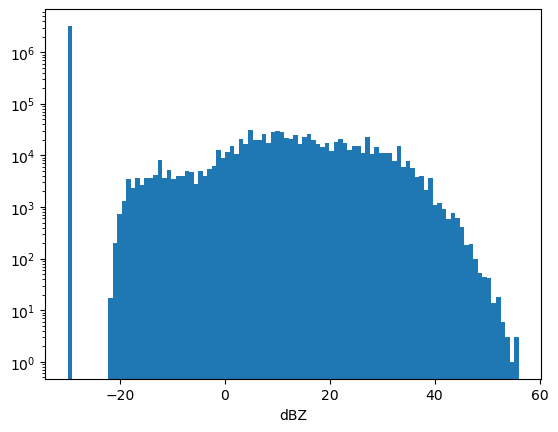

In [13]:
ds_radar.dBZ.plot.hist(bins=100, yscale='log');

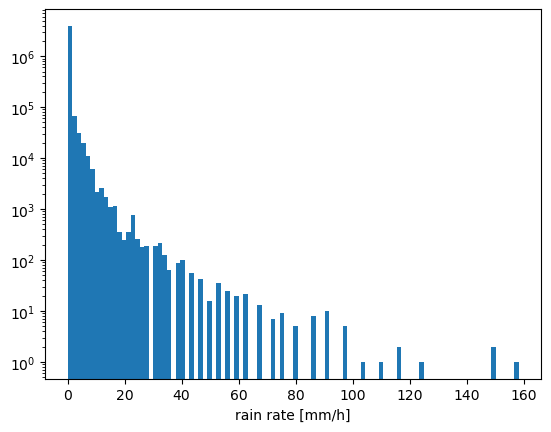

In [14]:
ds_radar.R.plot.hist(bins=100, yscale='log');

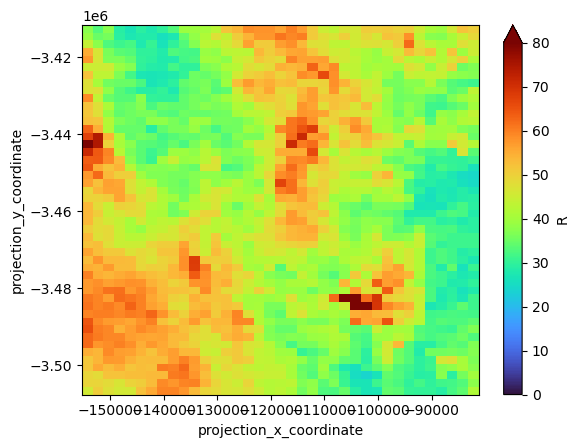

In [15]:
ds_radar.R.resample(time='1h').mean().sum(dim='time').plot(vmin=0, vmax=80, cmap='turbo')

In [16]:
ds_radar.R.encoding = {'zlib': True, 'complevel': 4, 'dtype': 'int', 'scale_factor': 0.01, '_FillValue': -9999}
ds_radar.drop_vars('dBZ').to_netcdf('../openmrg_rad_8d.nc')

## Process CML data

In [17]:
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

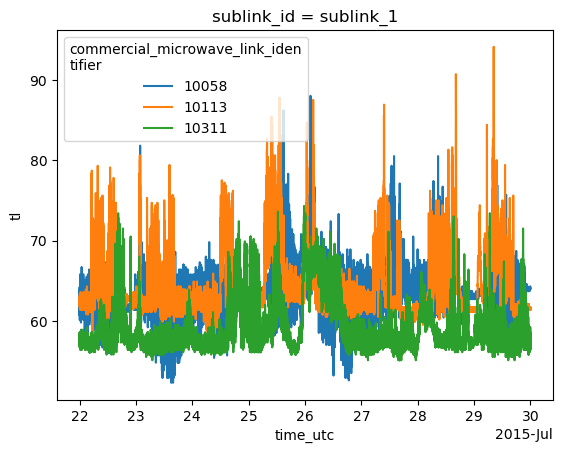

In [18]:
ds_cmls.where(qc_diurnalcicle, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

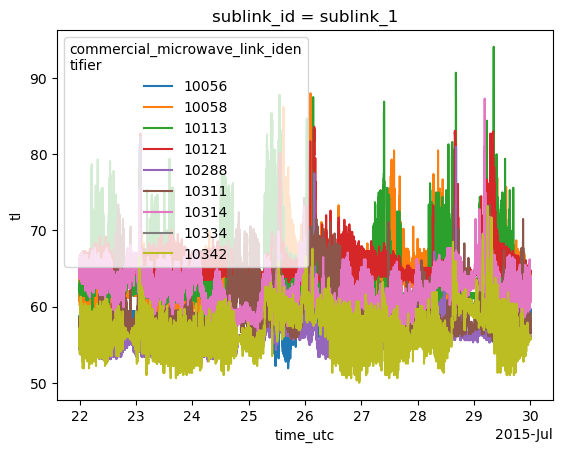

In [19]:
ds_cmls.where(qc_noisyperiods, drop=True).isel(sublink_id=0).tl.plot.line(x='time');

In [20]:
ds_cmls

<xarray.Dataset> Size: 604MB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 6kB 2.821e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 3kB 'v' 'v' 'v' 'v' ... 'v' 'v' 'v'
    length        (cml_id) float64 3kB 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Data variables:
    tsl           (time, sublink_id, cml_id) float32 201MB 1.0 0.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float32 201MB -46.0 -41.0 ... -49.2
    tl            (time, sublink_id, cml_id) float32 201MB 47.0 41.0 ... 49.2
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [74]:
# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar.R,
    ds_line_data=ds_cmls,
)

da_radar_along_cmls = grid_at_lines(ds_radar.R)
da_radar_along_cmls


# calculate wet periods
#ds_cmls['roll_std_threshold'] = 1.1 * ds_cmls['tl'].rolling(time=60, center=True).std().quantile(0.85, dim='time')
#ds_cmls['wet'] = ds_cmls.tl.rolling(time=60, center=True).std() > ds_cmls.roll_std_threshold
#ds_cmls['wet'] =    ds_cmls.tl.rolling(time=60).std() > 0.4
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)    

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  
    d=0.15, 
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  
    f_GHz=ds_cmls.frequency / 1000,  
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

In [75]:
# currently not used for wet-dry
#ds_cmls.roll_std_threshold.plot.hist(bins=100);

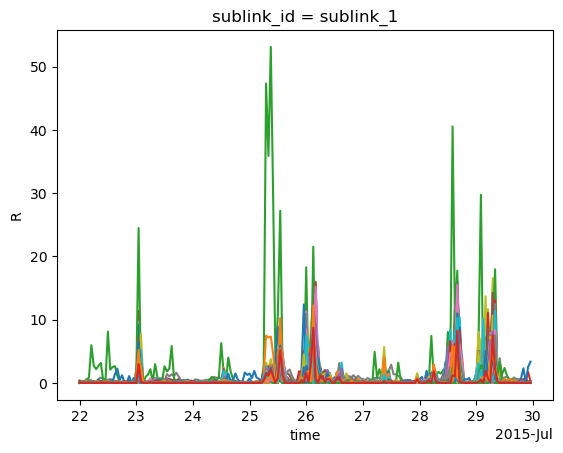

In [76]:
ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().plot.line(x='time', add_legend=False);

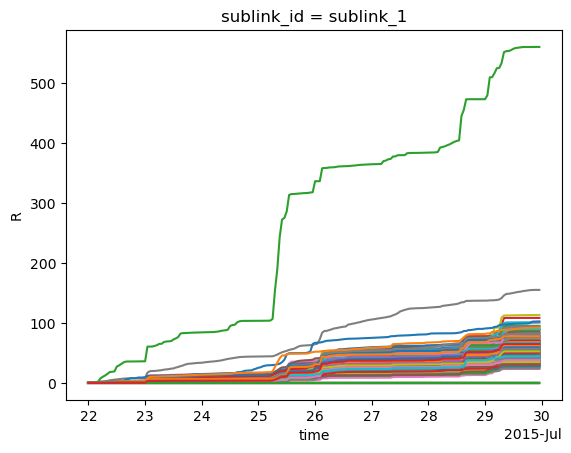

In [77]:
ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time', add_legend=False);

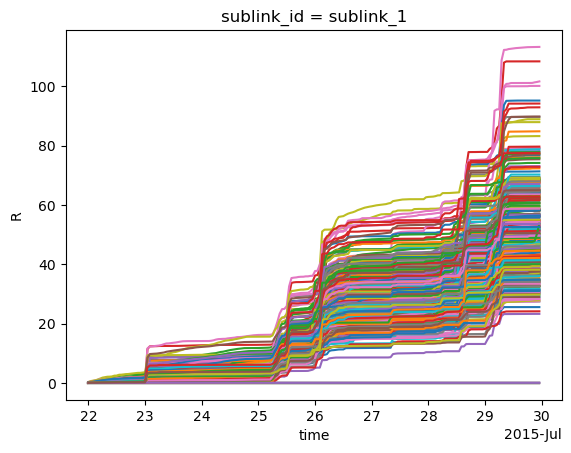

In [78]:
(
    ds_cmls
    .where(~qc_noisyperiods, drop=True)
    .isel(sublink_id=0)
    .R
    .resample(time='1h').mean()
    .cumsum(dim='time')
    .plot.line(x='time', add_legend=False)
);

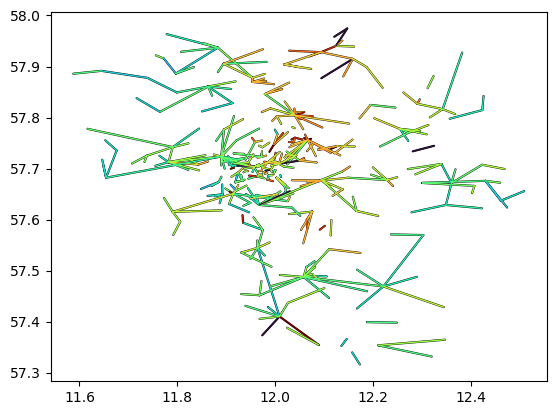

In [79]:
plg.plot_map.plot_lines(ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'), vmin=0, vmax=100)

<Axes: xlabel='lon', ylabel='lat'>

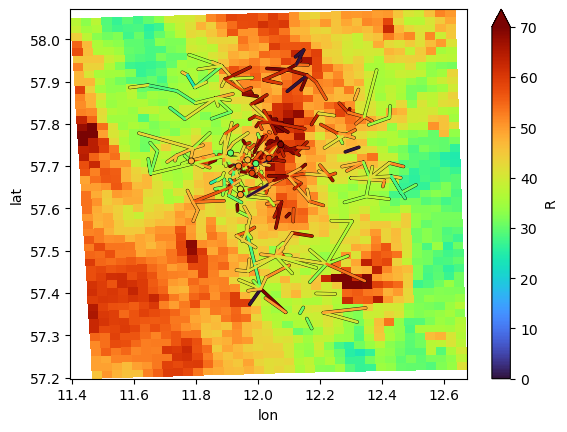

In [80]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time='1h').mean().sum(dim='time'),
    da_grid=ds_radar.R.resample(time='1h').mean().sum(dim='time'),
    da_gauges=ds_gauges_city.rainfall_amount.sum(dim='time'),
    vmin=0,
    vmax=70,
)

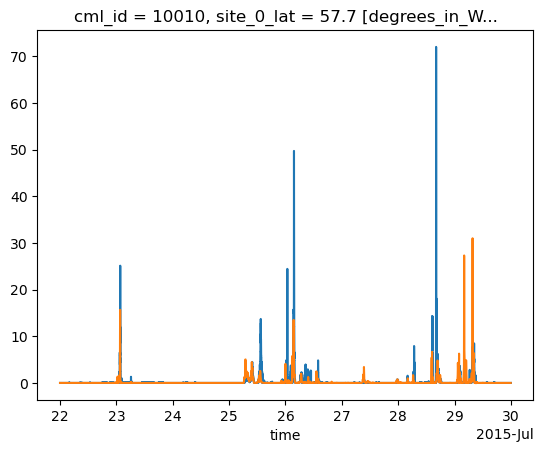

In [81]:
cml_id = 10010

ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.plot()
da_radar_along_cmls.sel(cml_id=cml_id).plot()

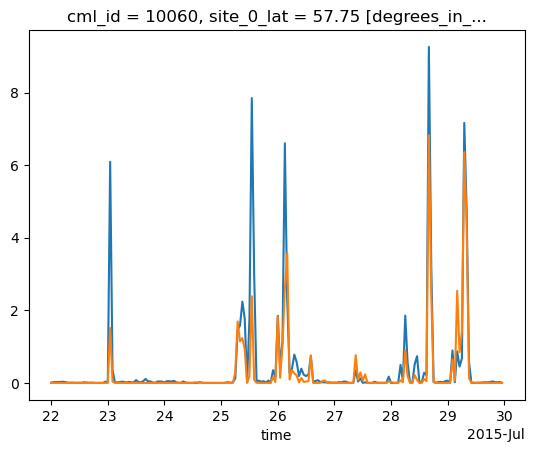

In [82]:
cml_id = 10060

ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean().plot()
da_radar_along_cmls.sel(cml_id=cml_id).resample(time='1h').mean().plot()

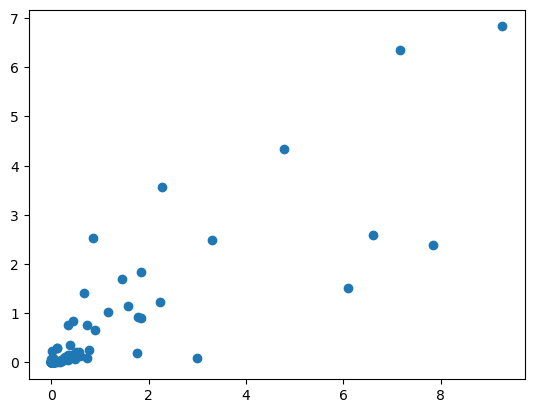

In [83]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).sel(cml_id=cml_id).R.resample(time='1h').mean(),
    da_radar_along_cmls.sel(cml_id=cml_id).resample(time='1h').mean(),
)

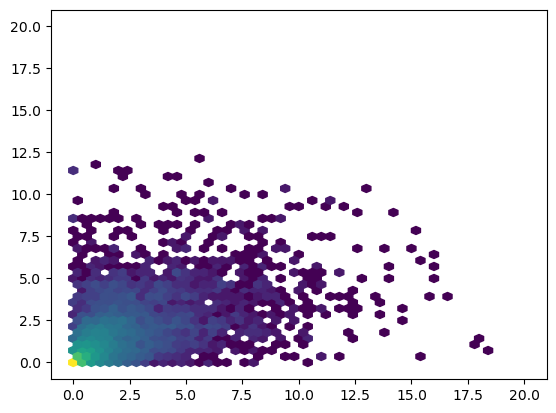

In [84]:
import matplotlib.pyplot as plt
plt.hexbin(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().data.flatten(),
    da_radar_along_cmls.resample(time='1h').mean().data.flatten(),
    gridsize=50,
    bins='log',
    extent=[0, 20, 0, 20],
)

(0.0, 100.0)

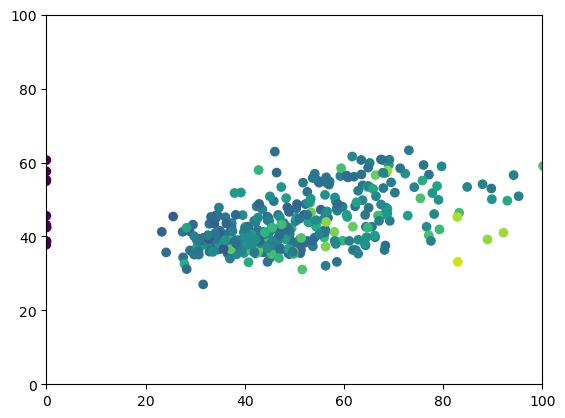

In [85]:
import matplotlib.pyplot as plt
plt.scatter(
    ds_cmls.isel(sublink_id=0).R.transpose().resample(time='1h').mean().sum(dim='time').data,
    da_radar_along_cmls.resample(time='1h').mean().sum(dim='time').data,
    c=(ds_cmls.isel(sublink_id=0).R > 0.1).sum(dim='time'),
)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [91]:
ds_cmls

<xarray.Dataset> Size: 3GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 6kB 2.821e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 3kB 'v' 'v' 'v' 'v' ... 'v' 'v' 'v'
    length        (cml_id) float64 3kB 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Data variables:
    tsl           (time, sublink_id, cml_id) float32 201MB 1.0 0.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float32 201MB -46.0 -41.0 ... -49.2
    tl            (time, sublink_id, cml_id) float32 201MB 47.0 41.0 ... 49.2
    wet           (time, cml_id) float64 201MB nan nan nan nan ... nan nan nan
    baseline      (sublink_id, cml_id, time) float64 403MB 47.0 47.0 ... 49.2
    A_obs         (time, sublink_id, cml_id) float64 403MB 0.0 0.0 ... 0.0 0.0
    waa           (sublink_id, cml_id, time) float64 403MB 0.0 0.0 ... 0.0 0.0
    A             (time, sublink_id, cml_id) float64 403MB 0.0 0.0 ... nan 0.0
    R             (sublink_id, cml_id, time) float64 403MB 0.0 0.0 ... 0.0 0.0
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [104]:
ds_cmls.drop_vars(['tl', 'wet', 'baseline', 'A_obs', 'waa', 'A']).to_netcdf(
    '../openmrg_cml_8d.nc', 
    encoding={
        'R': {'zlib': True, 'complevel': 4, 'dtype': 'int32', 'scale_factor': 0.01, '_FillValue': -9999},
        'tsl': {'zlib': True, 'complevel': 4, 'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -999},
        'rsl': {'zlib': True, 'complevel': 4, 'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -999}
    },
)

In [101]:
ds_cmls.rsl

<xarray.DataArray 'rsl' (time: 69120, sublink_id: 2, cml_id: 364)> Size: 201MB
array([[[-46. , -41. , -40.1, ..., -40.7, -39.8, -49.8],
        [-43.5, -41.3, -38.8, ..., -42. , -39.8, -49.2]],

       [[-46. , -41. , -40.1, ..., -40.7, -40.1, -49.8],
        [-43.5, -41.3, -38.8, ..., -42. , -39.5, -49.2]],

       [[-46. , -41. , -40.1, ..., -40.7, -39.8, -49.8],
        [-43.5, -41.3, -38.8, ..., -42. , -39.5, -49.2]],

       ...,

       [[-46. , -41.3, -40.1, ..., -40.7, -39.8, -50.1],
        [-43.5, -41.3, -38.8, ..., -42. , -39.5, -49.2]],

       [[-46. , -41.3, -40.1, ..., -40.4, -40.1, -50.1],
        [-43.5, -41.3, -38.8, ..., -42. , -39.5, -49.2]],

       [[-46. , -41.3, -40.1, ..., -40.7, -40.1, -50.1],
        [-43.5, -41.3, -38.8, ..., -42. , -39.5, -49.2]]], dtype=float32)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 6kB 2.821e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 3kB 'v' 'v' 'v' 'v' ... 'v' 'v' 'v'
    length        (cml_id) float64 3kB 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Attributes:
    units:        dBm
    coordinates:  cml_id, sublink_id, time
    long_name:    received_signal_level

In [33]:
STOP

NameError: name 'STOP' is not defined

## 1.2 Download OpenRainER dataset and prepare files with month with liqiud rain only

In [ ]:
# menaging AWS

#### Extracting radar along CML path for each month
from raw files again as its more meory efficient..

#### Prepare data for analysis


In [ ]:
ds_gauges=xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc").rainfall_amount.load()
ds_gauges=ds_gauges.where(ds_gauges.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [ ]:
ds_cml=xr.open_dataset("data/covi_2024_OpenRainER/OpenRainER_cmls.nc").load()
ds_cml=ds_cml.where(ds_cml.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [ ]:
ds_radar_along=xr.open_dataset("data/covi_2024_OpenRainER/RADadj_along_cml.nc").load()
ds_radar_along=ds_radar_along.where(ds_radar_along.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

#### Calculate distance between rain gauges and CMLs using [`poligrain`](https://poligrain.readthedocs.io/en/latest/index.html)

In [ ]:
# Project coordinates for rain gauges
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cml.coords["site_0_x"],
    ds_cml.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_0_lon, ds_cml.site_0_lat, "EPSG:25832"
)
(
    ds_cml.coords["site_1_x"],
    ds_cml.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cml.site_1_lon, ds_cml.site_1_lat, "EPSG:25832"
)

In [ ]:
max_distance = 2000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cml, ds_gauges, max_distance=max_distance, n_closest=1
)

In [ ]:
# remove all cml - gauge pairs that are not within 2 km
closest_neigbors = closest_neigbors.where(closest_neigbors.neighbor_id != None,drop=True)

####  Perpare reference data

In [ ]:
# getting the rain gauge time series from the nearest rain gauge for each CML (within 2 km)
reference_15min = xr.full_like(ds_cml.rsl, fill_value=np.nan).resample(time='15min').first().where(ds_gauges.time.dt.month.isin([4,5,6,7,8,9,10]), drop=True)

In [ ]:
for cmlid in tqdm(closest_neigbors.cml_id):
    tmp_ga_rain = (np.repeat(
        ds_gauges.sel(time=reference_15min.time).sel(id=closest_neigbors.sel(cml_id=cmlid).neighbor_id.values).values[:, np.newaxis],
        2,
        axis=1,))
    reference_15min.loc[dict(cml_id=cmlid)] = tmp_ga_rain[0]

reference_15min = reference_15min.to_dataset(name='rain_gauge_rainfall')

100%|██████████| 88/88 [00:00<00:00, 89.24it/s]


In [ ]:
# sort by cml_id before combining into one dataset
reference_15min = reference_15min.sortby(reference_15min.cml_id)
ds_radar_along =  ds_radar_along.sortby(ds_radar_along.cml_id)

In [ ]:
# add radar_along_cml to reference dataset
reference_15min['radar_along_cml'] = xr.full_like(reference_15min.rain_gauge_rainfall,fill_value=np.nan)

reference_15min['radar_along_cml'].loc[dict(sublink_id='channel1')]=ds_radar_along.rainfall_amount.T
reference_15min['radar_along_cml'].loc[dict(sublink_id='channel2')]=ds_radar_along.rainfall_amount.T

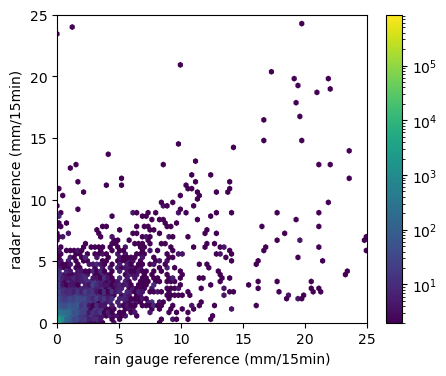

In [ ]:
plt.subplots(figsize=(5,4))
plt.hexbin(
    reference_15min.rain_gauge_rainfall.values.flatten(),
    reference_15min.radar_along_cml.values.flatten(),
    mincnt=1,bins='log')
plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel('rain gauge reference (mm/15min)')
plt.ylabel('radar reference (mm/15min)')
plt.colorbar();

In [ ]:
# save reference file
reference_15min.to_netcdf('data/covi_2024_OpenRainER/radar_gauge_15min_reference.nc')